In [11]:
# ====================== БЕЗ GOOGLE DRIVE - ВСЁ В ПАМЯТИ ======================
!pip install opencv-python scikit-learn numpy matplotlib -q

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

print("Начинаем создание системы распознавания рукописных символов...")

# ====================== СОЗДАЕМ ВИРТУАЛЬНЫЙ ДАТАСЕТ В ПАМЯТИ ======================
def create_virtual_dataset():
    """Создает виртуальный датасет символов в оперативной памяти."""
    symbols = [")", "(", "+", "-", ",", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "X", "h", "t", "*", "w", "y"]

    print(f"Создаем виртуальный датасет для {len(symbols)} символов...")

    dataset = {}
    for symbol in symbols:
        symbol_images = []

        # Создаем 50 вариантов каждого символа
        for i in range(50):
            # Создаем пустое изображение
            img = np.ones((64, 64), dtype=np.uint8) * 255

            # Случайные параметры для разнообразия
            font = random.choice([
                cv2.FONT_HERSHEY_SIMPLEX,
                cv2.FONT_HERSHEY_COMPLEX,
                cv2.FONT_HERSHEY_TRIPLEX
            ])

            font_size = random.uniform(1.2, 2.0)
            thickness = random.randint(2, 4)

            # Позиция символа (немного варьируем)
            x_pos = random.randint(15, 25)
            y_pos = random.randint(35, 45)

            # Рисуем символ
            cv2.putText(img, symbol, (x_pos, y_pos), font, font_size, 0, thickness)

            # Добавляем "рукописные" эффекты
            # 1. Легкий поворот
            if random.random() > 0.5:
                angle = random.uniform(-8, 8)
                h, w = img.shape[:2]
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                img = cv2.warpAffine(img, M, (w, h))

            # 2. Шум (имитация неравномерности чернил)
            noise = np.random.normal(0, random.randint(5, 12), img.shape).astype(np.uint8)
            img = cv2.add(img, noise)

            # 3. Иногда добавляем размытие
            if random.random() > 0.8:
                img = cv2.GaussianBlur(img, (3, 3), 0)

            # Инвертируем (черный текст на белом фоне)
            img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)[1]

            symbol_images.append(img)

        dataset[symbol] = symbol_images

    print(f" Создано {sum(len(images) for images in dataset.values())} изображений")
    return dataset

# Создаем датасет
virtual_dataset = create_virtual_dataset()
symbols = list(virtual_dataset.keys())

Начинаем создание системы распознавания рукописных символов...
Создаем виртуальный датасет для 21 символов...
 Создано 1050 изображений


In [12]:
# ====================== ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ ======================
def prepare_training_data(dataset, test_size=0.2):
    """Подготавливает данные для обучения модели."""
    X, y = [], []

    for symbol, images in dataset.items():
        for img in images:
            # Нормализуем размер
            img_resized = cv2.resize(img, (32, 32))
            X.append(img_resized.flatten())
            y.append(symbol)

    X = np.array(X)
    y = np.array(y)

    # Разделяем на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, X, y

print("\n Подготавливаем данные для обучения...")
X_train, X_test, y_train, y_test, X_all, y_all = prepare_training_data(virtual_dataset)

print(f" Обучающая выборка: {len(X_train)} образцов")
print(f" Тестовая выборка: {len(X_test)} образцов")
print(f" Количество классов: {len(set(y_all))}")


 Подготавливаем данные для обучения...
 Обучающая выборка: 840 образцов
 Тестовая выборка: 210 образцов
 Количество классов: 21


In [13]:
def train_best_knn(X_train, y_train, X_test, y_test):
    """Обучает несколько моделей KNN и выбирает лучшую."""
    print("\n Обучаем модели KNN с разными параметрами...")

    models = {}
    accuracies = {}

    k_values = [1, 3, 5, 7]
    for k in k_values:
        print(f"   KNN с k={k}...")
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        model.fit(X_train, y_train)

        # Оценка точности
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[k] = accuracy
        models[k] = model

        print(f"     Точность: {accuracy:.2%}")

    # Выбираем лучшую модель
    best_k = max(accuracies, key=accuracies.get)
    best_model = models[best_k]
    best_accuracy = accuracies[best_k]

    print(f"\n Лучшая модель: KNN с k={best_k}")
    print(f" Точность лучшей модели: {best_accuracy:.2%}")

    return best_model, best_k, best_accuracy

# Обучаем модель
best_model, best_k, best_accuracy = train_best_knn(X_train, y_train, X_test, y_test)


 Обучаем модели KNN с разными параметрами...
   KNN с k=1...
     Точность: 66.67%
   KNN с k=3...
     Точность: 59.05%
   KNN с k=5...
     Точность: 54.76%
   KNN с k=7...
     Точность: 51.43%

 Лучшая модель: KNN с k=1
 Точность лучшей модели: 66.67%


In [14]:
def generate_handwritten_string(target_string, dataset):
    """Создает изображение рукописной строки."""
    images = []

    for char in target_string:
        if char in dataset and dataset[char]:
            # Берем случайное изображение символа
            char_img = random.choice(dataset[char])
            # Конвертируем обратно в обычный формат (белый фон, черный текст)
            char_img = cv2.threshold(char_img, 128, 255, cv2.THRESH_BINARY_INV)[1]
            images.append(char_img)

    if not images:
        return None

    # Объединяем символы с пробелами
    result = images[0]
    for img in images[1:]:
        # Добавляем пробел между символами
        spacer = np.ones((img.shape[0], 20), dtype=np.uint8) * 255
        result = np.hstack([result, spacer, img])

    # Добавляем поля вокруг
    result = cv2.copyMakeBorder(result, 20, 20, 30, 30, cv2.BORDER_CONSTANT, value=255)

    return result

def extract_characters_from_string(image):
    """Выделяет символы из изображения строки."""
    if image is None:
        return []

    # Инвертируем (черный текст на белом фоне)
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Находим отдельные символы
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Сортируем слева направо
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Пропускаем слишком маленькие области (шум)
        if w > 10 and h > 10:
            # Вырезаем символ
            char_img = image[y:y+h, x:x+w]
            # Нормализуем
            char_img = cv2.resize(char_img, (32, 32))
            char_img = cv2.threshold(char_img, 200, 255, cv2.THRESH_BINARY_INV)[1]
            characters.append(char_img)

    return characters

def recognize_handwritten_string(model, string_image):
    """Распознает строку на изображении."""
    characters = extract_characters_from_string(string_image)

    if not characters:
        return ""

    result = []
    for char_img in characters:
        # Преобразуем в вектор признаков
        features = char_img.flatten().reshape(1, -1)
        prediction = model.predict(features)[0]
        result.append(prediction)

    return ''.join(result)


ТЕСТИРОВАНИЕ СИСТЕМЫ РАСПОЗНАВАНИЯ

 Тест 1: '123+456'
Распознано: 'h5w,Xh8ww6w'
Точность: 0.0%
Различия:
     Позиция 0: '1' → 'h'
     Позиция 1: '2' → '5'
     Позиция 2: '3' → 'w'
     Позиция 3: '+' → ','
     Позиция 4: '4' → 'X'
     Позиция 5: '5' → 'h'
     Позиция 6: '6' → '8'


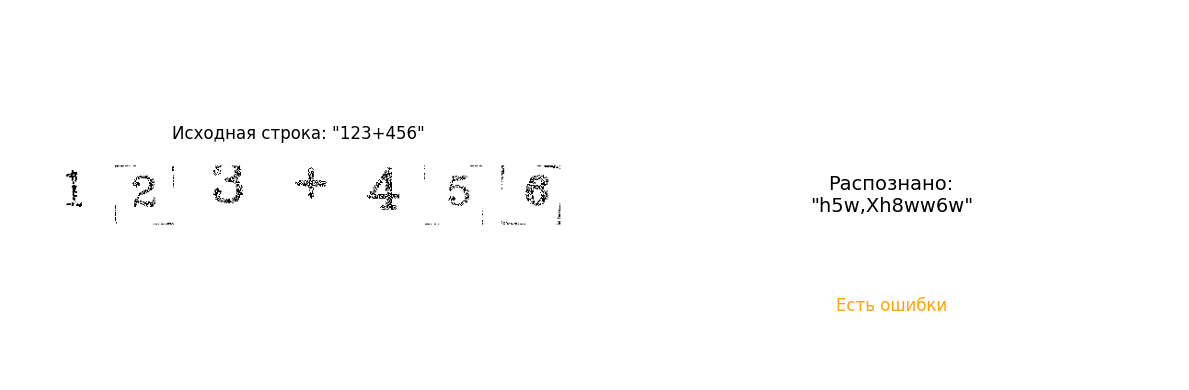


 Тест 2: 'X*(y+3)'
Распознано: 'w5w(64+'
Точность: 0.0%
Различия:
     Позиция 0: 'X' → 'w'
     Позиция 1: '*' → '5'
     Позиция 2: '(' → 'w'
     Позиция 3: 'y' → '('
     Позиция 4: '+' → '6'
     Позиция 5: '3' → '4'
     Позиция 6: ')' → '+'


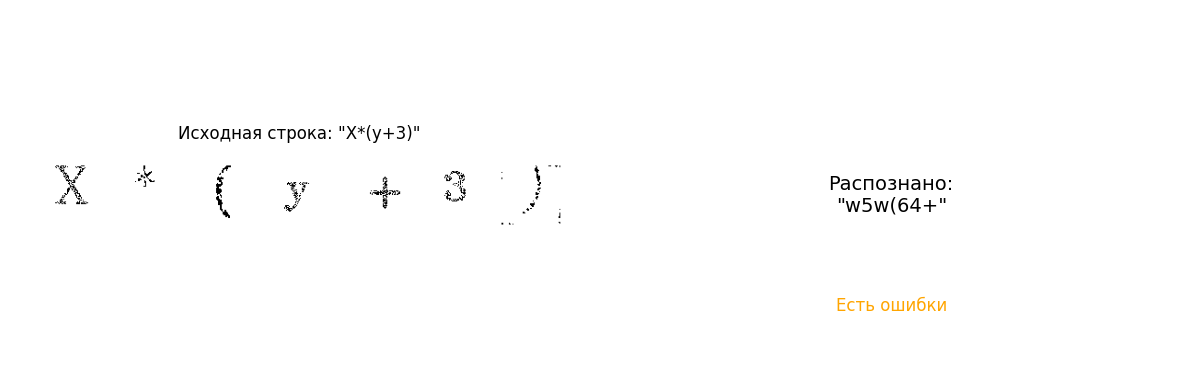


 Тест 3: '7-2,8+9'
Распознано: '5463w*h'
Точность: 0.0%
Различия:
     Позиция 0: '7' → '5'
     Позиция 1: '-' → '4'
     Позиция 2: '2' → '6'
     Позиция 3: ',' → '3'
     Позиция 4: '8' → 'w'
     Позиция 5: '+' → '*'
     Позиция 6: '9' → 'h'


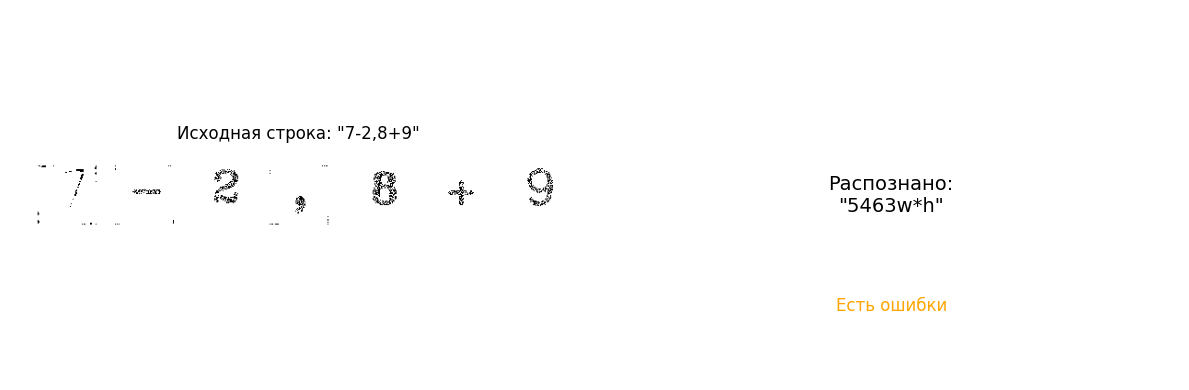


 Тест 4: 'h*w+t'
Распознано: '(wwwh6'
Точность: 20.0%
Различия:
     Позиция 0: 'h' → '('
     Позиция 1: '*' → 'w'
     Позиция 3: '+' → 'w'
     Позиция 4: 't' → 'h'


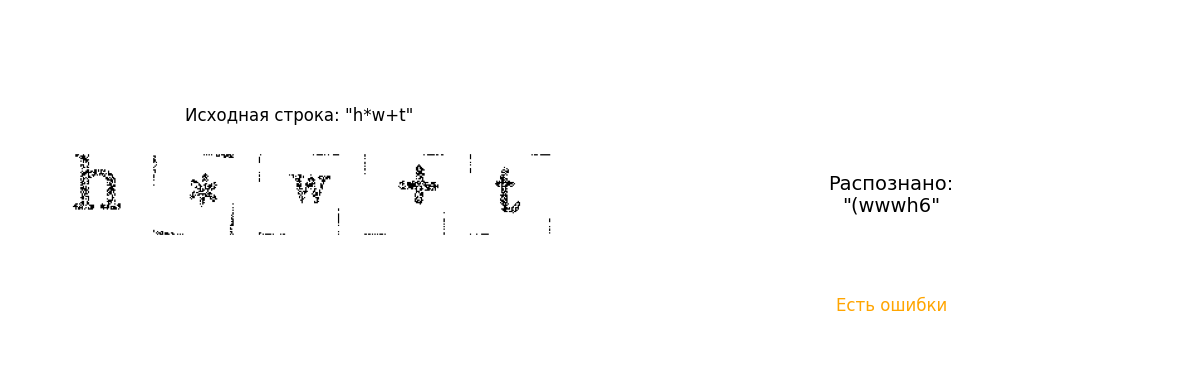


 Тест 5: '0123456789'
Распознано: '0h955y*hXy5,20'
Точность: 10.0%
Различия:
     Позиция 1: '1' → 'h'
     Позиция 2: '2' → '9'
     Позиция 3: '3' → '5'
     Позиция 4: '4' → '5'
     Позиция 5: '5' → 'y'
     Позиция 6: '6' → '*'
     Позиция 7: '7' → 'h'
     Позиция 8: '8' → 'X'
     Позиция 9: '9' → 'y'


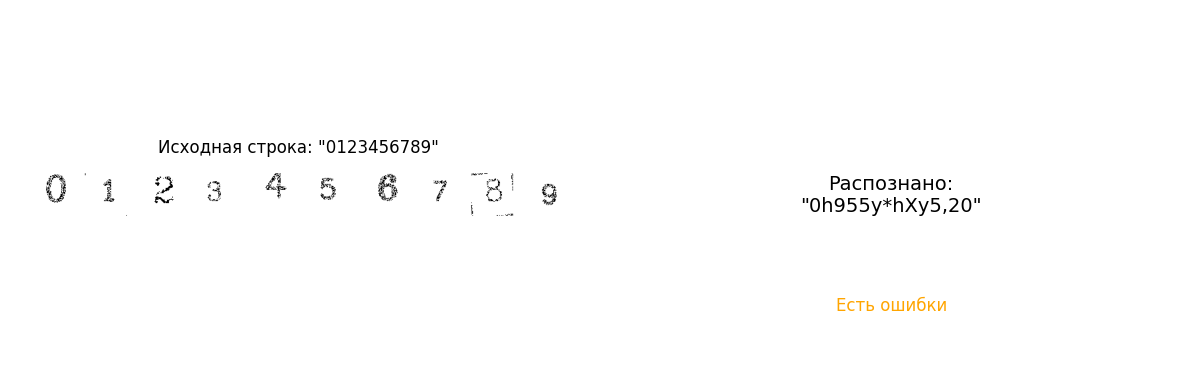


 Тест 6: 'hello'
Распознано: 'h'
Точность: 20.0%
Различия:


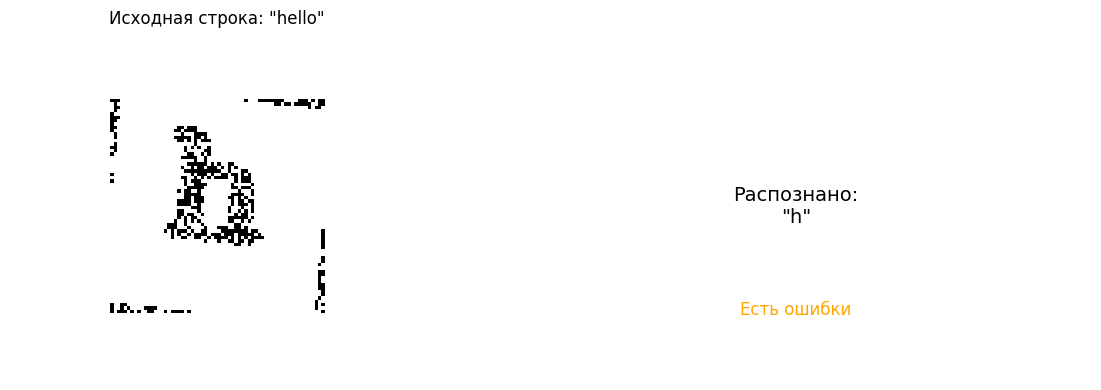


ИНТЕРАКТИВНЫЙ РЕЖИМ
Введите строки для распознавания (только допустимые символы):
Допустимые символы: )(+-,0123456789Xht*wy
Введите 'exit' для выхода


 Случайный тест 1: '(7X80'
Распознано: 'tyh74'


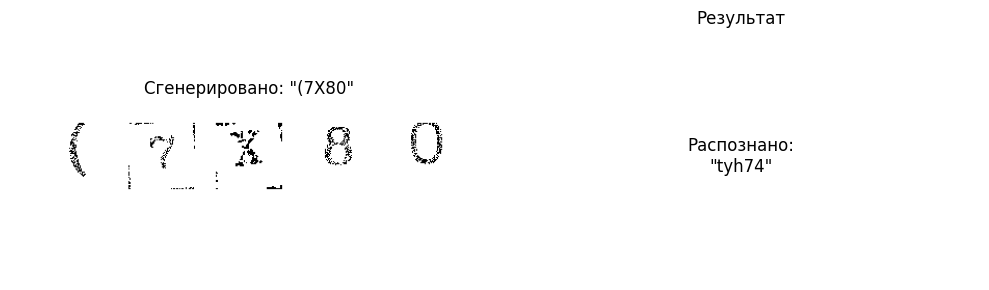

Точность: 0.0%

 Случайный тест 2: '1X16430'
Распознано: 'w41wh26t'


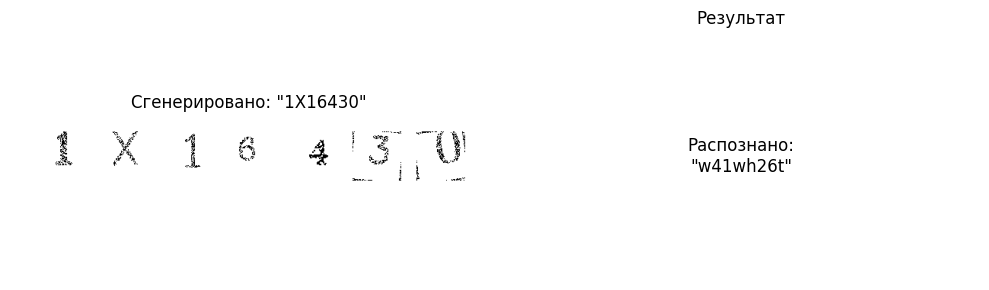

Точность: 14.3%

 Случайный тест 3: '6th731(('
Распознано: '*hwh3y9w8)h'


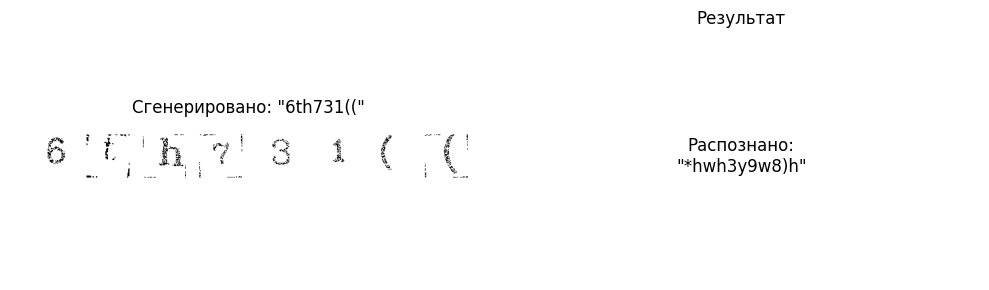

Точность: 12.5%

 ИТОГОВЫЙ ОТЧЕТ
Лучшая модель: KNN с k=1
Точность на тестовой выборке: 66.67%
Обучено на: 840 образцах
Поддерживаемых символов: 21
Размерность признаков: 1024

 Отчет по классификации основных символов:
              precision    recall  f1-score   support

           (       1.00      0.70      0.82        10
           )       0.88      0.70      0.78        10
           *       1.00      0.90      0.95        10
           +       0.70      0.70      0.70        10
           ,       0.00      0.00      0.00         0
           -       0.64      0.90      0.75        10
           0       0.80      0.80      0.80        10
           1       0.47      0.70      0.56        10
           2       0.67      0.20      0.31        10
           3       0.60      0.60      0.60        10
           4       1.00      0.50      0.67        10
           5       0.88      0.70      0.78        10
           6       0.38      0.30      0.33        10
           7       1.00

In [15]:
print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ СИСТЕМЫ РАСПОЗНАВАНИЯ")
print("="*60)

# Тестовые строки
test_strings = [
    "123+456",
    "X*(y+3)",
    "7-2,8+9",
    "h*w+t",
    "0123456789",
    "hello",  # Будет распознано как "h" и другие символы
]

for i, test_str in enumerate(test_strings, 1):
    print(f"\n Тест {i}: '{test_str}'")

    # Создаем изображение строки
    string_img = generate_handwritten_string(test_str, virtual_dataset)

    if string_img is None:
        print("Не удалось создать изображение")
        continue

    # Распознаем строку
    recognized = recognize_handwritten_string(best_model, string_img)

    print(f"Распознано: '{recognized}'")

    # Сравниваем
    if test_str == recognized:
        print("Идеальное совпадение!")
    else:
        # Вычисляем точность
        min_len = min(len(test_str), len(recognized))
        if min_len > 0:
            correct = sum(1 for j in range(min_len) if test_str[j] == recognized[j])
            accuracy = correct / len(test_str)
            print(f"Точность: {accuracy:.1%}")

        # Показываем различия
        print("Различия:")
        for j in range(min_len):
            if test_str[j] != recognized[j]:
                print(f"     Позиция {j}: '{test_str[j]}' → '{recognized[j]}'")

    # Визуализируем
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Исходное изображение
    axes[0].imshow(string_img, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title(f'Исходная строка: "{test_str}"', fontsize=12)
    axes[0].axis('off')

    # Результат
    axes[1].text(0.5, 0.5, f'Распознано:\n"{recognized}"',
                ha='center', va='center', fontsize=14)

    if test_str == recognized:
        axes[1].text(0.5, 0.2, 'СОВПАДАЕТ!',
                    ha='center', va='center', fontsize=12, color='green')
    else:
        axes[1].text(0.5, 0.2, 'Есть ошибки',
                    ha='center', va='center', fontsize=12, color='orange')

    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# ====================== ИНТЕРАКТИВНЫЙ РЕЖИМ ======================
print("\n" + "="*60)
print("ИНТЕРАКТИВНЫЙ РЕЖИМ")
print("="*60)
print("Введите строки для распознавания (только допустимые символы):")
print(f"Допустимые символы: {''.join(symbols)}")
print("Введите 'exit' для выхода\n")

# Создаем несколько случайных тестов
for test_num in range(1, 4):
    # Генерируем случайную строку
    random_length = random.randint(5, 8)
    random_string = ''.join(random.choices(symbols, k=random_length))

    print(f"\n Случайный тест {test_num}: '{random_string}'")

    # Создаем и распознаем
    random_img = generate_handwritten_string(random_string, virtual_dataset)

    if random_img is not None:
        random_recognized = recognize_handwritten_string(best_model, random_img)

        print(f"Распознано: '{random_recognized}'")

        # Быстрая визуализация
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(random_img, cmap='gray')
        plt.title(f'Сгенерировано: "{random_string}"')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'Распознано:\n"{random_recognized}"',
                ha='center', va='center', fontsize=12)
        plt.title('Результат')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Статистика
        if random_string == random_recognized:
            print("Отличный результат!")
        else:
            accuracy = sum(1 for a, b in zip(random_string, random_recognized) if a == b) / len(random_string)
            print(f"Точность: {accuracy:.1%}")

# ====================== ОТЧЕТ О РАБОТЕ СИСТЕМЫ ======================
print("\n" + "="*60)
print(" ИТОГОВЫЙ ОТЧЕТ")
print("="*60)

print(f"Лучшая модель: KNN с k={best_k}")
print(f"Точность на тестовой выборке: {best_accuracy:.2%}")
print(f"Обучено на: {len(X_train)} образцах")
print(f"Поддерживаемых символов: {len(symbols)}")
print(f"Размерность признаков: {X_train.shape[1]}")

# Матрица ошибок для основных символов
print("\n Отчет по классификации основных символов:")
common_symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '(', ')']
y_pred_all = best_model.predict(X_test)

# Фильтруем только общие символы
mask = np.isin(y_test, common_symbols)
if np.any(mask):
    print(classification_report(y_test[mask], y_pred_all[mask], zero_division=0))

print("\n Система распознавания рукописных символов успешно создана!")
print("="*60)